# Introduction

1. Train a binary classification of "have hand" or "have no hand". It is a simple task, which will be a tiny neural network.
2. Find the saliency map of a input image.
3. Build a segmentation based on the saliency map.
4. Use traditional computer vision method to find the hand

# Load libraries

In [2]:
import pandas as pd
import keras
import os
import numpy as np
from sklearn.metrics import log_loss
from keras import Model,Sequential
from keras.layers import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import glob
import random
from mtcnn import MTCNN

# 1. Make Train Data

## 1.1 Images with hand

In [4]:
image_paths = glob.glob('opencv_method/dataset/made_hand/*_rgb.jpg')
images_length = len(image_paths)
print("there are",images_length,"images having hand.")

there are 40519 images having hand.


In [3]:
input_image_size = 256
label_ratio_x = input_image_size/480
label_ratio_y = input_image_size/640

def read_img(path):
    image = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, (input_image_size,input_image_size), interpolation = cv2.INTER_AREA) 
    return resized

In [33]:
train_ratio = 0.4
validataion_ration = 0.05

num_train = int(images_length*train_ratio)
num_valid = int(images_length*validataion_ration)

train_images = image_paths[0:num_train]
valid_images = image_paths[num_train:num_valid+num_train]
print("there are", len(train_images), "train images, and", len(valid_images), "validation images.")

there are 16207 train images, and 2025 validation images.


In [34]:
X = []
y = []
for img in tqdm(train_images):
    X.append(read_img(img))
    y.append(1)
    
val_X = []
val_y = []
for img in tqdm(valid_images):
    val_X.append(read_img(img))
    val_y.append(1)

print("Total length : there are", len(X), "train images, and", len(val_X), "validation images.")


Total length : there are 16207 train images, and 2025 validation images.


## 1.2 Images without hand

In [35]:
out_image_size = [480,640]
def make_back_ground_image(path, left_top_ratio, resize_ratio_seed):    
    back = cv2.imread(path)
    back = cv2.cvtColor(back, cv2.COLOR_BGR2RGB)
    
    resize_ratio = max(out_image_size[0]/ back.shape[0], out_image_size[1]/ back.shape[1])
    resize_ratio = resize_ratio / resize_ratio_seed
    
    back = cv2.resize(back, (0, 0), fx=resize_ratio, fy=resize_ratio, interpolation=cv2.INTER_NEAREST)
 
    left_top = [0,0]
    left_top[0] = int((back.shape[0]-out_image_size[0])*left_top_ratio[0])
    left_top[1] = int((back.shape[1]-out_image_size[1])*left_top_ratio[1])
    
    back_new = back[left_top[0]:left_top[0]+out_image_size[0],left_top[1]:left_top[1]+out_image_size[1], : ]
    back_new = cv2.resize(back_new, (input_image_size,input_image_size), interpolation = cv2.INTER_AREA) 
    return back_new

In [36]:
background_image_path = glob.glob('video_images/*.jpg')
background_length = len(background_image_path)

num_train = int(background_length*train_ratio)
num_valid = int(background_length*validataion_ration)

train_images = background_image_path[0:num_train]
valid_images = background_image_path[num_train:num_valid+num_train]

num_back_each = int(images_length/background_length)
for path in tqdm(train_images):
    for n_back in range(num_back_each):
        bleft_top_seed_x = random.random()
        bleft_top_seed_y = random.random()
        bratio_seed = random.uniform(0.4, 1)

        back_ori = make_back_ground_image(path, [bleft_top_seed_x,bleft_top_seed_y],bratio_seed)
        X.append(back_ori)
        y.append(0)
        
for path in tqdm(valid_images):
    for n_back in range(num_back_each):
        bleft_top_seed_x = random.random()
        bleft_top_seed_y = random.random()
        bratio_seed = random.uniform(0.4, 1)

        back_ori = make_back_ground_image(path, [bleft_top_seed_x,bleft_top_seed_y],bratio_seed)
        val_X.append(back_ori)
        val_y.append(0)

print("there are", len(train_images)*num_back_each, "train images, and", len(valid_images)*num_back_each, "validation images.")


there are 16104 train images, and 1980 validation images.


In [37]:
print("Total length : there are", len(X), "train images, and", len(val_X), "validation images.")

Total length : there are 32311 train images, and 4005 validation images.


## 1.3 Randomly shuffle the images

In [41]:
def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

In [42]:
X, y = shuffle(X,y)
val_X, val_y = shuffle(val_X,val_y)

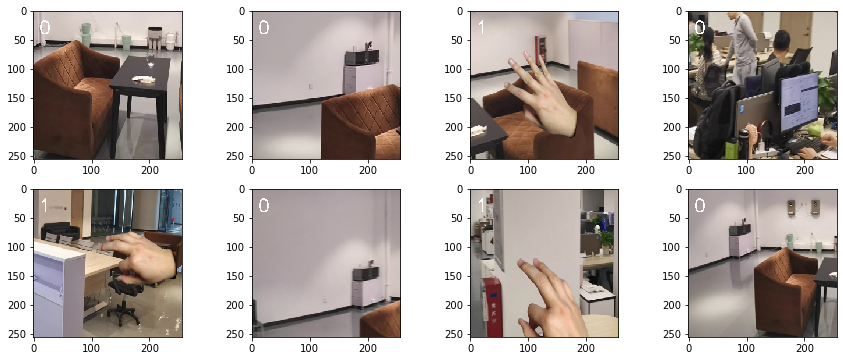

In [44]:
num_plot = [2,4]

count = 1
plt.figure(figsize=(15,6))
for i in range(num_plot[0]):
    for j in range(num_plot[1]):
        plt.subplot(num_plot[0],num_plot[1], count)
        count += 1
        idx = int(random.random() * len(X))
        
        image = X[idx]
        label_test = y[idx]
        
        cv2.putText(image, str(label_test), (10, 40), cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), 2)

        plt.imshow(image)

# 2. Build the model

from (https://www.kaggle.com/unkownhihi/starter-kernel-with-cnn-model-ll-lb-0-69235)

In [3]:
def InceptionLayer(a, b, c, d):
    def func(x):
        x1 = Conv2D(a, (1, 1), padding='same', activation='elu')(x)
        
        x2 = Conv2D(b, (1, 1), padding='same', activation='elu')(x)
        x2 = Conv2D(b, (3, 3), padding='same', activation='elu')(x2)
            
        x3 = Conv2D(c, (1, 1), padding='same', activation='elu')(x)
        x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='elu')(x3)
        
        x4 = Conv2D(d, (1, 1), padding='same', activation='elu')(x)
        x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='elu')(x4)
        y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
        return y
    return func

In [4]:
def define_model(shape=(256,256,3)):
    x = Input(shape = shape)
    
    x1 = InceptionLayer(1, 4, 4, 2)(x)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
    
    x2 = InceptionLayer(2, 4, 4, 2)(x1)
    x2 = BatchNormalization()(x2)        
    x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
    x3 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
    x4 = Conv2D(16, (5, 5), padding='same', activation = 'elu')(x3)
    x4 = BatchNormalization()(x4)
    if shape==(256,256,3):
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
    else:
        x4 = MaxPooling2D(pool_size=(2, 2), padding='same')(x4)
        
    y = Flatten()(x4)
    y = Dropout(0.5)(y)
    y = Dense(16)(y)
    y = LeakyReLU(alpha=0.1)(y)
    y = Dropout(0.5)(y)
    y = Dense(1, activation = 'sigmoid')(y)
    model=Model(inputs = x, outputs = y)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4))
    #model.summary()
    return model

In [6]:
df_model=define_model()
df_model.load_weights('MESO/MesoInception_DF')
f2f_model=define_model()
f2f_model.load_weights('MESO/MesoInception_F2F')

# 3. Train the model

In [48]:
from keras.callbacks import LearningRateScheduler
import gc

In [49]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

## 3.1 Train with pretrained model

In [7]:
model = define_model((256,256,3))
#model.load_weights('../input/meso-pretrain/MesoInception_DF')
for new_layer, layer in zip(model.layers[1:-8], df_model.layers[1:-8]):
    new_layer.set_weights(layer.get_weights())
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 4)  16          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 256, 256, 4)  16          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 2)  8           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_49 

In [66]:
lrs = [1e-3,1e-3,5e-4,5e-4,2e-4,   1e-4,1e-4,1e-4,1e-4]
def schedule(epoch):
    return lrs[epoch]

In [67]:
history = LossHistory()
model.fit([X],[y],validation_split=0.1,epochs=len(lrs),callbacks=[LearningRateScheduler(schedule),history])

Train on 29079 samples, validate on 3232 samples
Epoch 1/9
29079/29079 [==============================] - 78s 3ms/step - loss: 0.1541 - val_loss: 0.0057
Epoch 2/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0133 - val_loss: 1.2348
Epoch 3/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0058 - val_loss: 0.0217
Epoch 4/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0026 - val_loss: 6.3247e-05
Epoch 5/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0025 - val_loss: 1.6326e-06
Epoch 6/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0014 - val_loss: 4.8724e-06
Epoch 7/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0019 - val_loss: 9.3979e-06
Epoch 8/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0016 - val_loss: 7.4854e-05
Epoch 9/9
29079/29079 [==============================] - 74s 3ms/step - loss: 0.0011 - val_loss: 3.

4005/4005 [==============================] - 5s 1ms/step
Test score: 0.3225287662232556


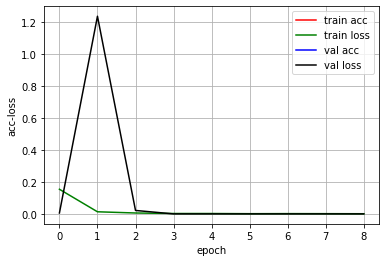

In [71]:
score = model.evaluate([val_X], [val_y], verbose=1)
print('Test score:', score)

history.loss_plot('epoch')

In [72]:
pred = model.predict([val_X])

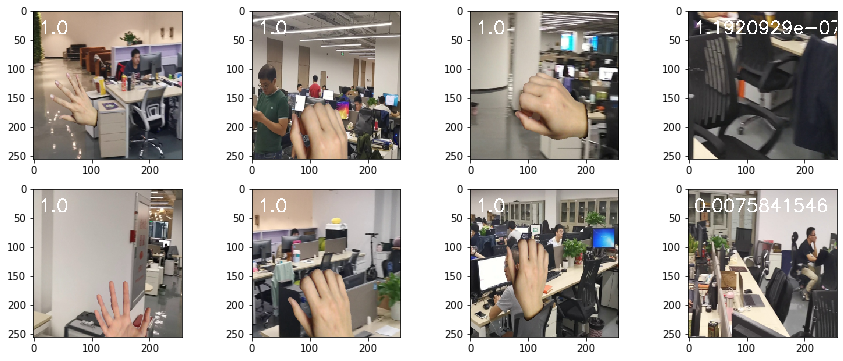

In [83]:
num_plot = [2,4]
count = 1
plt.figure(figsize=(15,6))
for i in range(num_plot[0]):
    for j in range(num_plot[1]):
        plt.subplot(num_plot[0],num_plot[1], count)
        count += 1
        idx = int(random.random() * len(val_X))
        
        image = val_X[idx].copy()
        label_test = pred[idx][0]
        
        cv2.putText(image, str(label_test), (10, 40), cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), 2)

        plt.imshow(image)

In [82]:
# make sample background
cap = cv2.VideoCapture(0)
if not (cap.isOpened()):
    print("Could not open video device")
else:  
    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        resized = cv2.resize(frame, (256,256), interpolation = cv2.INTER_AREA) 
        label_test = model.predict([[resized]])[0][0]
        out_str = ""
        if(label_test < 0.5):
            out_str = "no hand"
        else:
            out_str = "has hand"
        
        cv2.putText(frame, out_str, (10, 40), cv2.FONT_HERSHEY_SIMPLEX,1.0, (255, 255, 255), 2)
        # Display the resulting frame
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

In [76]:
model.save('MESO/model_save.h5')
model.save_weights('MESO/model_weight_save.h5')

In [63]:
K.clear_session()
del model
gc.collect()

77960

## 3.2 Saliency map

(https://raghakot.github.io/keras-vis/visualizations/saliency/)

pip install git+https://github.com/raghakot/keras-vis.git -U

In [1]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import load_model

Using TensorFlow backend.


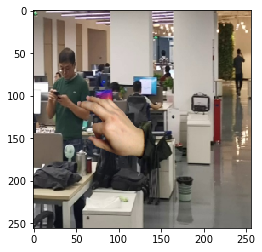

In [17]:
image_test = read_img(image_paths[1])
plt.imshow(image_test)

In [13]:
model = load_model('MESO/model_save.h5')

In [15]:
layer_idx = 32
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

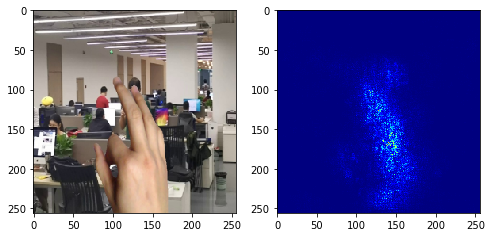

In [29]:
image_test = read_img(image_paths[2])
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(image_test)
grads = visualize_saliency(model, layer_idx, filter_indices=[0], seed_input=image_test)
# Plot with 'jet' colormap to visualize as a heatmap.
plt.subplot(122)
plt.imshow(grads, cmap='jet')

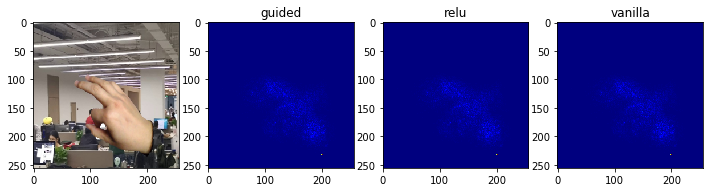

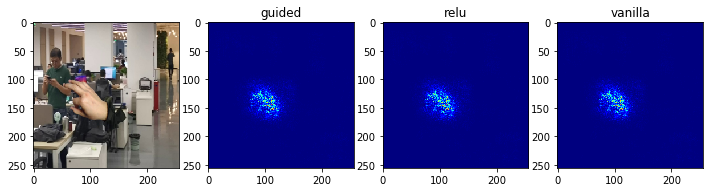

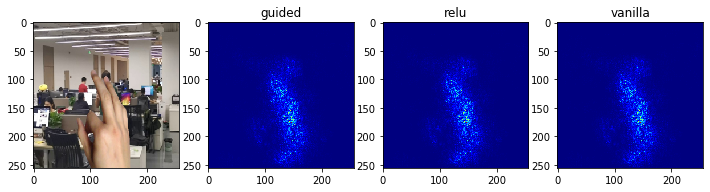

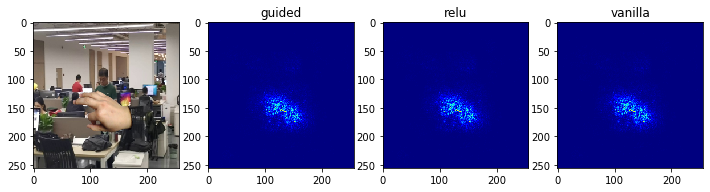

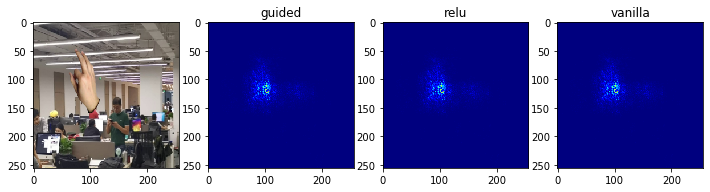

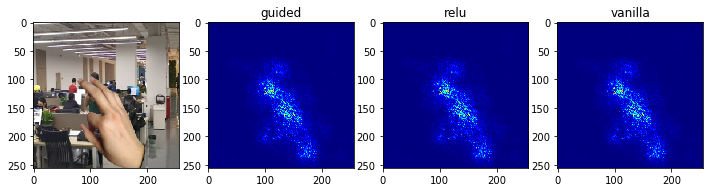

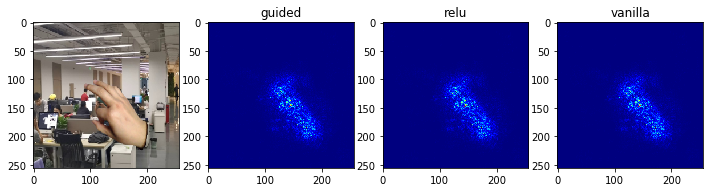

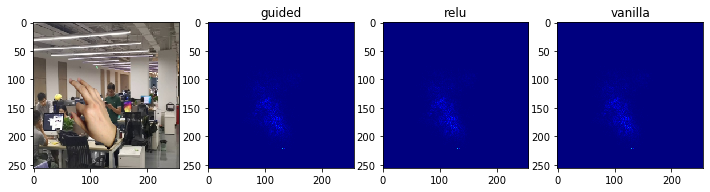

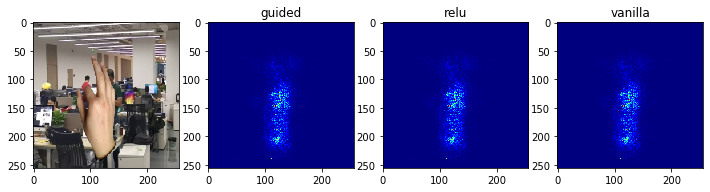

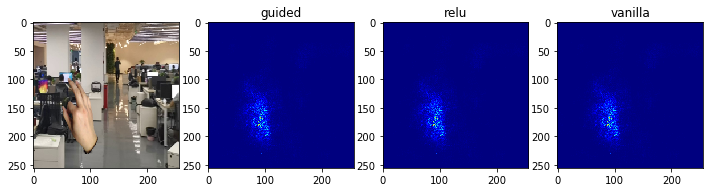

In [30]:
for i in range(10):
    image_test = read_img(image_paths[i])
    plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.imshow(image_test)
    
    id_t = 2
    for modifier in ['guided', 'relu', None]:  # None is vanilla
        grads = visualize_saliency(model, layer_idx, filter_indices=[0],
                               seed_input=image_test, backprop_modifier=modifier)
        plt.subplot(1,4,id_t)
        id_t += 1
        if modifier is None:
            modifier = 'vanilla'
        plt.title(modifier)
        plt.imshow(grads, cmap='jet')

## 3.2 Train with multiply folds

In [ ]:
kfolds = 5
losses = []

models = []
i = 0
while len(models) < kfolds:
    model=define_model((150,150,3))
    if i == 0:
        model.summary()
    model.fit([X],[y],epochs=2,callbacks=[LearningRateScheduler(schedule)])
    pred=model.predict([val_X])
    loss=log_loss(val_y,pred)
    losses.append(loss)
    print('fold '+str(i)+' model loss: '+str(loss))
    if loss<0.68:
        models.append(model)
    else:
        print('loss too bad, retrain!')
    K.clear_session()
    del model
    gc.collect()
    i += 1

In [ ]:
def prediction_pipline(X,two_times=False):
    preds=[]
    for model in tqdm(models):
        pred=model.predict([X])
        preds.append(pred)
    preds=sum(preds)/len(preds)
    if two_times:
        return larger_range(preds,2)
    else:
        return preds
def larger_range(model_pred,time):
    return (((model_pred-0.5)*time)+0.5)

In [ ]:
best_model_pred=models[losses.index(min(losses))].predict([val_X])

In [ ]:
model_pred=prediction_pipline(val_X)